In [1]:
from essentia import Pool, array
from essentia.standard import *

In [2]:
# In this example we are going to look at how to perform some onset detection
# and mark them on the audio using the AudioOnsetsMarker algorithm.
#
# Onset detection consists of two main phases:
#  1- we need to compute an onset detection function, which is a function
#     describing the evolution of some parameters, which might be representative
#     of whether we might find an onset or not
#  2- performing the actual onset detection, that is given a number of these
#     detection functions, decide where in the sound there actually are onsets


# we're going to work with a file specified as an argument in the command line
# try:
#     filename = "stingray-piano-arp.m4a"
# except:
#     print("usage: %s <audiofile>" % sys.argv[0])
#     sys.exit()

# don't forget, we can actually instantiate and call an algorithm on the same line!
print('Loading audio file...')
# loader = essentia.standard.MonoLoader(filename="stingray-piano-arp.m4a")
loader = essentia.standard.MonoLoader(filename="lost-piano-jam.MP3")
sr = 44100;

audio = loader()
file_name = 'lost-piano-jam.MP3'
import IPython
IPython.display.Audio(file_name)
# display(data=audio, rate=sr)


Loading audio file...


In [3]:
# Phase 1: compute the onset detection function
# The OnsetDetection algorithm tells us that there are several methods available in Essentia,
# let's do two of them

od1 = OnsetDetection(method='hfc')
od2 = OnsetDetection(method='complex')

# let's also get the other algorithms we will need, and a pool to store the results

w = Windowing(type = 'hann')
fft = FFT() # this gives us a complex FFT
c2p = CartesianToPolar() # and this turns it into a pair (magnitude, phase)

pool = Pool()



In [4]:
# let's get down to business
print('Computing onset detection functions...')
for frame in FrameGenerator(audio, frameSize = 1024, hopSize = 512):
    mag, phase, = c2p(fft(w(frame)))
    pool.add('features.hfc', od1(mag, phase))
    pool.add('features.complex', od2(mag, phase))

Computing onset detection functions...


In [5]:
# Phase 2: compute the actual onsets locations
onsets = Onsets()

print('Computing onset times...')
onsets_hfc = onsets(# this algo expects a matrix, not a vector
                    array([ pool['features.hfc'] ]),

                    # you need to specify weights, but as there is only a single
                    # function, it doesn't actually matter which weight you give it
                    [ 1 ])

onsets_complex = onsets(array([ pool['features.complex'] ]), [ 1 ])

# print(onsets_hfc.shape)

Computing onset times...


In [6]:
# and mark them on the audio, which we'll write back to disk
# we use beeps instead of white noise to mark them, as it's more distinctive
print('Writing audio files to disk with onsets marked...')

# mark the 'hfc' onsets:
marker = AudioOnsetsMarker(onsets=onsets_hfc, type='beep')
marked_audio = marker(audio)
MonoWriter(filename='onsets_hfc.wav')(marked_audio)

# mark the 'complex' onsets:
marker = AudioOnsetsMarker(onsets=onsets_complex, type='beep')
# mark the audio and make it an mp3 file, all in 1 line, just because we can!
MonoWriter(filename='onsets_complex.mp3', format='mp3')(marker(audio))


# and now go listen to your nice audio files to see which onset detection function
# works better!
print('All done!')
print('Results are written to the files \'onsets_hfc.wav\' and \'onsets_complex.mp3\'')

Writing audio files to disk with onsets marked...
All done!
Results are written to the files 'onsets_hfc.wav' and 'onsets_complex.mp3'


In [7]:
print(audio.shape)

(3830400,)


In [8]:
# to translate, imagine 'energies' is actually your array of audio samples
# 'onsetFrames' would be a list of sample indices corresponding to onsets.
# 'notes' is therefore a list of arrays, each of which contains the
# samples between a given onset and the next onset (or in case of the final
# onset, the samples from that onset to the end of the signal)

notes = []
onsetFrames = onsets_hfc
numOnsets = onsetFrames.shape[0]
if numOnsets == 1:
    notes.append(audio[onsetFrames[0]:])
for i in range(numOnsets):
    if i == 0:
        continue
    nStart = int(sr * onsetFrames[i - 1])
    nEnd = int(sr * onsetFrames[i])
    notes.append(audio[nStart:nEnd])
    if i == numOnsets - 1:
        notes.append(audio[int(sr * onsetFrames[i]):])
   
print(len(notes))
print(notes[5].shape)

182
(12800,)


In [9]:
from pathlib import Path
import json
from scipy.io.wavfile import write, read
from IPython.display import Audio
# write audio samples to a wav file (audioFs is sampling rate)
wavPath = Path("test.wav")
write(wavPath.resolve(), rate=sr, data=notes[90])
# read audio samples from a wav file
testFs, testWav = read(wavPath.resolve())

# create a dict to store data
jsonObj = {"testThingy": 7}
# convert it to a json string
testJson = json.dumps(jsonObj)
# choose a path to save the file
jsonPath = Path("test.json")
# write the text to the file
jsonPath.write_text(testJson)
# read the text from the file
with jsonPath.open(mode="rt") as jsonFile:
    testJson = jsonFile.read()
    jsonObj = json.loads(testJson)
print(jsonObj)
Audio(data=testWav, rate=testFs)

{'testThingy': 7}


In [10]:
import sqlite3
from sqlite3 import Error


def create_connection(db_file):
    """ create a database connection to a SQLite database """
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        print(sqlite3.version)
        return conn
    except Error as e:
        print(e)

db = create_connection(r"voice-mementos.db")

2.6.0


In [11]:
def create_table(conn, create_table_sql):
    """ create a table from the create_table_sql statement
    :param conn: Connection object
    :param create_table_sql: a CREATE TABLE statement
    :return:
    """
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
sql_create_memos_table = """ CREATE TABLE memos (
                                    id integer PRIMARY KEY,
                                    name text NOT NULL
                                ); """

sql_create_notes_table = """CREATE TABLE tasks (
                                    id integer PRIMARY KEY,
                                    durationSeconds float NOT NULL,
                                    path text,
                                    memo_id integer NOT NULL,
                                    FOREIGN KEY (memo_id) REFERENCES memos (id)
                                );"""

# create tables
if db is not None:
    # create memos table
    create_table(db, sql_create_memos_table)

    # create notes table
    create_table(db, sql_create_notes_table)
else:
    print("Error! cannot create the database connection.")

In [12]:
def create_memo(conn, memo):
    """
    Create a new project into the projects table
    :param conn:
    :param project:
    :return: project id
    """
    sql = ''' INSERT INTO memos(name)
              VALUES(?) '''
    cur = conn.cursor()
    print("memo is", memo)
    cur.execute(sql, memo)
    conn.commit()
    return cur.lastrowid

def create_note(conn, note):
    """
    Create a new task
    :param conn:
    :param task:
    :return:
    """

    sql = ''' INSERT INTO tasks(durationSeconds,path,memo_id)
              VALUES(?,?,?) '''
    cur = conn.cursor()
    cur.execute(sql, note)
    conn.commit()

    return cur.lastrowid

memo is ('lost-piano-jam.MP3',)


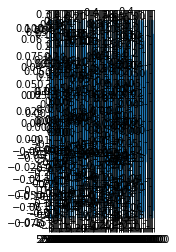

In [17]:
# putting it all together
import uuid

from pylab import *

# handy way to create (almost definitely, universally) unique identifiers for database entries etc
def random_uuid():
    return str(uuid.uuid4())
# maybe this name comes from the original audio file
clip_name = "lost-piano-jam"

# initialize an object to store data for the clip
memo = (file_name,)
memo_id = create_memo(db, memo)

data = {}
data[clip_name] = {}
data[clip_name]["note-data"] = []
# process each detected note
plotIdx = 1
for i in range(numOnsets):
    if notes[i].shape[0] < 22050:
        continue
    unique_id = random_uuid()
    # plot the waveform
    subplot(1, numOnsets, plotIdx)
    plotIdx += 1
    plot(notes[i])
   
    # choose a path to save the wav file
    path = Path(f"{file_name.replace('.', '-')}/note_{i}.wav")
    Path(f"{file_name.replace('.', '-')}").mkdir(parents=True, exist_ok=True)
   
    # annotations for this note
    entry = {
        "uuid": unique_id,
        "note-idx": i,
        "durationSec": len(notes[i]) / sr,
        "path": str(path.resolve())
    }
    # add it to the data object
    data[clip_name]["note-data"].append(entry)
    
    durationSeconds = len(notes[i]) / sr
    note = (durationSeconds, str(path.resolve()), memo_id)
    
    create_note(db, note)
   
    # write the individual note to its own wav file
    write(path.resolve(), rate=sr, data=notes[i])
   
# choose a path to save the metadata file
jsonPath = Path(f"{clip_name}_data.json")
# write the text to the file
jsonPath.write_text(json.dumps(data)); 
